In [1]:
path_ragers_850='gs20201102_78_850_reduced_crop.fits'

In [2]:
# Read the source
from astropy.io import fits
source = fits.open(path_ragers_850)

In [3]:
# import wcs from astropy
from astropy.wcs import WCS
sci_map = source[0].data[0]
sci_header = source[0].header
var_map = source[1].data[0]
var_header = source[1].header
wcs = WCS(source[0].header)
wcs

Set OBSGEO-B to    19.822833 from OBSGEO-[XYZ].
Set OBSGEO-H to     4120.022 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


WCS Keywords

Number of WCS axes: 3
CTYPE : 'RA---TAN'  'DEC--TAN'  'WAVE'  
CRVAL : 127.161583333333  25.4741944444444  0.00085  
CRPIX : 211.0  210.0  1.0  
PC1_1 PC1_2 PC1_3  : 1.0  0.0  0.0  
PC2_1 PC2_2 PC2_3  : 0.0  1.0  0.0  
PC3_1 PC3_2 PC3_3  : 0.0  0.0  1.0  
CDELT : -0.00055555555555553  0.000555555555555541  7e-05  
NAXIS : 421  420  1

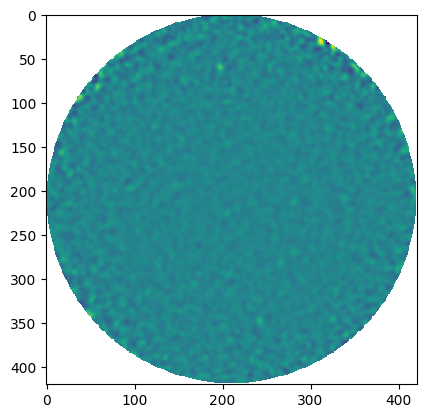

In [4]:
import matplotlib.pyplot as plt
plt.imshow(sci_map)

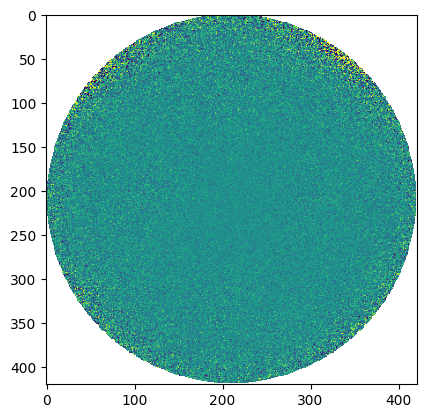

In [6]:
import numpy as np
noise_map = np.random.normal(0,np.sqrt(var_map),size=(var_map.shape))
plt.imshow(noise_map,vmin=-6,vmax=6)

In [7]:
# get the formatting correct for a NDF
hdu1 = fits.PrimaryHDU(noisHote_map.reshape(1,*var_map.shape),header=sci_header)
hdu2 = fits.ImageHDU(var_map.reshape(1,*var_map.shape),header=var_header)
hdul = fits.HDUList([hdu1,hdu2])
hdul.writeto('synthetic_noise.fits',overwrite=True)

In [10]:
fwhm = 15
pxscl = 2
size = (101,101)
size = (size[0]-1)/2, (size[1]-1)/2
print(size)
radius = 420

# make_pdf
r_deg = radius/3600
area = np.pi*r_deg**2
dn_norm = lambda s: (7180/3.7)*(s/2.5)**-1.5*np.exp(-s/2.5) #dN/ds
# dn_norm = lambda s: (3300/3.7)*(s/3.7)**-1.4*np.exp(-s/3.7) #dN/ds
s_min = 0.5
s_max = 50
step = 0.05

# why choose 0.05

s = np.arange(s_min,s_max+step,step) # [0 0.05 0.1 0.15 ... 50]
num = dn_norm(s)*area*step #dN
# num = dn_norm(s)*step #dN
summ = np.sum(num) #N

prob = num/summ


sources = np.random.choice(s,size=int(summ),p=prob) #flux of generated sources
# print(num)
print(sources.max(),sources.min())
print(len(sources))

(50.0, 50.0)
8.850000000000007 0.5
391


In [11]:
# open the noise map
noise_map = fits.open('synthetic_noise.fits')[0].data[0]
noise_map_size = noise_map.shape

In [12]:
ind = np.argwhere(~np.isnan(noise_map)) #get the non nan index
positions = ind[np.random.randint(len(ind),size=len(sources))] #randomly select len(source) amount of index 
err = noise_map[tuple(zip(*positions))] #get the value of all selected index in the noise map
positions_delta = np.random.uniform(-0.5,0.5,size=(len(positions),2)) #randomly generate a delta for each position

In [14]:
# convert x and y positions to ra and dec
w = wcs.wcs_pix2world(*(positions + positions_delta)[:,::-1].T,1,1)
coord = [[wx/15,wy] for wx, wy, wz in np.transpose(w)]

In [15]:
x = np.linspace(start=-size[0],stop=size[0],num=int(2*size[0]+1)) # [-50,-49,-48,...,49,50]
y = np.linspace(-size[1],size[1],int(2*size[1]+1)) # [-50,-49,-48,...,49,50]
x,y = np.meshgrid(x,y) #create y row of x, and x row of y

In [16]:
def gauss2d(x,y,mx,my,sx,sy):
    return (1/(2*np.pi*sx*sy)) * np.exp(-((x-mx)**2/(2*sx**2) + (y-my)**2/(2*sy**2)))

In [17]:
for s, pos, pos_d in zip(sources,positions,positions_delta): 
    z = gauss2d(x, y, mx=pos_d[0], my=pos_d[1], sx=fwhm/(pxscl*2.355), sy=fwhm/(pxscl*2.355)) #2.355 is the fwhm to sigma conversion
    z = s*z/np.max(z)
    bounds = np.s_[None if pos[0] < size[0] else int(pos[0] - size[0]):int(pos[0] + size[0] + 1),
                                None if pos[1] < size[1] else int(pos[1] - size[1]):int(pos[1] + size[1] + 1)]

    gauss_bounds = np.s_[None if pos[0] > size[0] else int(size[0] - pos[0]): None if noise_map_size[0] - pos[0] > size[0] else int(size[0] + noise_map_size[0] - pos[0]),
                                None if pos[1] > size[1] else int(size[1] - pos[1]): None if noise_map_size[1] - pos[1] > size[1] else int(size[1] + noise_map_size[1] - pos[1])]

    noise_map[bounds] += z[gauss_bounds]
    

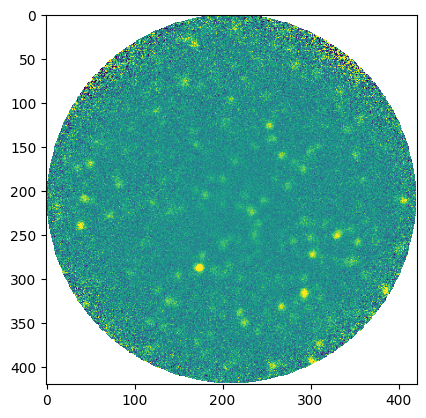

In [18]:
plt.imshow(noise_map,vmin=-6,vmax=6)

In [19]:
hdu1 = fits.PrimaryHDU(noise_map.reshape(1,*var_map.shape),header=sci_header)
hdu2 = fits.ImageHDU(var_map.reshape(1,*var_map.shape),header=var_header)
hdul = fits.HDUList([hdu1,hdu2])
hdul.writeto('synthetic_noise_with_generated_sources.fits',overwrite=True)

RUN IN TERMINTAL 

fits2ndf synthetic_noise_with_generated_sources.fits steady.sdf 


In [126]:
from starlink import picard
picard.scuba2_matched_filter(['steady.sdf'])

Use of uninitialized value $ENV{"USER"} in concatenation (.) or string at /home/mingkang/starlink_build_20230212/bin/oracdr/src/lib/perl5/ORAC/Core.pm line 865.
Use of uninitialized value in subroutine entry at /home/mingkang/starlink_build_20230212/bin/oracdr/src/lib/perl5/ORAC/Basic.pm line 156.


Picard Says: No display will be used
Picard Says: Pre-starting mandatory monoliths...Done
Checking for next data file: /home/mingkang/Documents/SIF3004/steady.sdf
Storing: steady
Picard Says: Creating temporary bad observation rules file
A new group 20201102#-1 has been created
Overriding PICARD instrument class to PICARD_SCUBA2_850
Sorting Groups
REDUCING: steady
Using recipe SCUBA2_MATCHED_FILTER specified on command-line


Use of uninitialized value in subroutine entry at /home/mingkang/starlink_build_20230212/bin/oracdr/src/lib/perl5/ORAC/Group.pm line 419, <DATA> line 1676.


Processing data for 5C7.269

Calling _SCUBA2_MATCHED_FILTER_: apply a matched-filter to reduced SCUBA-2 maps
Creating PSF image, normalizing, smoothing and subtracting from original: done
Applying matched filter to steady, 
   smoothing and subtracting from original: done
Recipe took 1.876 seconds to evaluate and execute.

Picard processing complete
Processed one recipe, which completed successfully
Exiting...

Picard Says: Goodbye


oracoutput(runlog='/home/mingkang/Documents/SIF3004/PICARDworking3u_jrs59/picard_9958.log', outdir='/home/mingkang/Documents/SIF3004/PICARDworking3u_jrs59', datafiles=['/home/mingkang/Documents/SIF3004/PICARDworking3u_jrs59/steady_mf.sdf', '/home/mingkang/Documents/SIF3004/PICARDworking3u_jrs59/steady_psf.sdf'], imagefiles=[], logfiles=['/home/mingkang/Documents/SIF3004/PICARDworking3u_jrs59/log.group'], status=0, pid=9958)

Run terminal 

cupid  

findclumps in=steady_mf.sdf out=detection.sdf outcat=detection.FIT

In [23]:
# calculate the completeness 
from astropy.io import fits
import numpy as np
import pandas as pd

# read the detection file
detection = fits.open('detection.FIT')[1].data
detection = pd.DataFrame(detection)

In [26]:
detection

,PIDENT,Peak1,Peak2,Cen1,Cen2,Size1,Size2,Sum,Peak,Volume
0,1,127.223803,25.600848,127.223512,25.600599,3.169708,1.743734,281.427572,18.204522,183.998389
1,2,127.016979,25.465235,127.016491,25.466230,3.290088,6.022182,575.008870,13.238813,399.996861
2,3,127.230577,25.596956,127.231018,25.596308,3.718531,3.546019,416.656748,12.791442,271.997648
3,4,127.245826,25.381393,127.246277,25.381176,3.921816,2.957827,363.863169,11.682520,283.998123
4,5,127.211995,25.355853,127.212487,25.356368,4.532680,4.131329,415.410783,10.279823,351.997404
...,...,...,...,...,...,...,...,...,...,...
63,64,127.277344,25.545260,127.276356,25.544869,6.064954,1.725308,171.983686,7.534516,195.998569
64,65,127.114244,25.358631,127.114029,25.358646,2.446553,1.392882,115.405926,9.921821,127.999109
65,66,127.242892,25.589172,127.243202,25.589057,1.330446,0.363974,58.160764,39.845414,59.999490
66,67,127.237967,25.593619,127.237524,25.593385,2.444434,2.297890,100.275337,7.751680,107.999063


In [133]:
len(detection)/len(sources)

0.19825072886297376

In [21]:
detection_peak = detection['Peak']

NameError: name 'detection' is not defined

In [141]:
# bin the peak value of the detection
bins = np.arange(0,20)
hist_detection, hist_edge = np.histogram(detection_peak,bins=bins)
hist_generate, hist_edge = np.histogram(sources,bins=bins)

In [142]:
completeness = hist_detection/hist_generate

/tmp/ipykernel_3778/2979127080.py:1: RuntimeWarning: divide by zero encountered in divide
  completeness = hist_detection/hist_generate
/tmp/ipykernel_3778/2979127080.py:1: RuntimeWarning: invalid value encountered in divide
  completeness = hist_detection/hist_generate


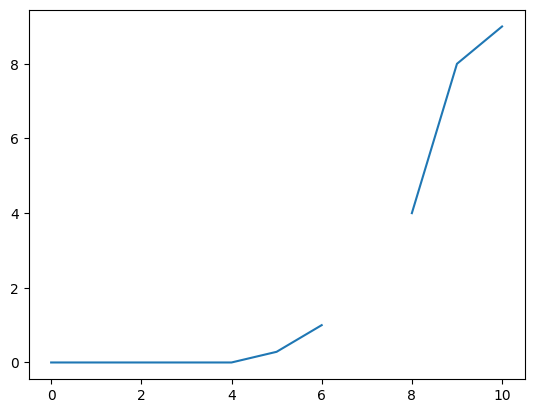

In [143]:
import matplotlib.pyplot as plt
plt.plot(bins[:-1],completeness)

In [145]:
completeness

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.28571429, 1.        ,        inf, 4.        , 8.        ,
       9.        ,        inf,        inf,        inf,        inf,
              nan,        inf,        inf,        inf])

In [20]:
hist_detection

NameError: name 'hist_detection' is not defined

In [147]:
hist_generate

array([163, 109,  31,  17,   6,   7,   5,   0,   3,   1,   1,   0,   0,
         0,   0,   0,   0,   0,   0])

In [56]:
sources.size

343

In [109]:
from starlink import picard
picard.crop_scuba2_images(['gs20201102_78_850_reduced.sdf'],recpars='MAP_RADIUS=420,CROP_METHOD=circle')

Use of uninitialized value $ENV{"USER"} in concatenation (.) or string at /home/mingkang/starlink_build_20230212/bin/oracdr/src/lib/perl5/ORAC/Core.pm line 865.
Use of uninitialized value in subroutine entry at /home/mingkang/starlink_build_20230212/bin/oracdr/src/lib/perl5/ORAC/Basic.pm line 156.


Picard Says: No display will be used
Picard Says: Pre-starting mandatory monoliths...Done
Checking for next data file: /home/mingkang/Documents/SIF3004/gs20201102_78_850_reduced.sdf
Storing: gs20201102_78_850_reduced
Picard Says: Creating temporary bad observation rules file
A new group 20201102#-1 has been created
Overriding PICARD instrument class to PICARD_SCUBA2_850
Sorting Groups
REDUCING: gs20201102_78_850_reduced
Using recipe CROP_SCUBA2_IMAGES specified on command-line
Processing data for 5C7.269

Calling _CROP_SCUBA2_IMAGE_: trim image to specified map size
Trimming image to specified map size


Use of uninitialized value in subroutine entry at /home/mingkang/starlink_build_20230212/bin/oracdr/src/lib/perl5/ORAC/Group.pm line 419, <DATA> line 1676.


Output image will be a circle of radius 420 arcsec
Masking the weights and exposure time images...
Removing temporary files...
Checking gs20201102_78_850_reduced_tmpmask...	Removing
Checking gs20201102_78_850_reduced_crop...	Keeping extension
Recipe took 0.910 seconds to evaluate and execute.

Picard processing complete
Processed one recipe, which completed successfully
Exiting...

Picard Says: Goodbye


oracoutput(runlog='/home/mingkang/Documents/SIF3004/PICARDworkingv_8psudr/picard_9544.log', outdir='/home/mingkang/Documents/SIF3004/PICARDworkingv_8psudr', datafiles=['/home/mingkang/Documents/SIF3004/PICARDworkingv_8psudr/gs20201102_78_850_reduced_crop.sdf'], imagefiles=[], logfiles=['/home/mingkang/Documents/SIF3004/PICARDworkingv_8psudr/log.group'], status=0, pid=9544)